# Full Versions: [Variant 1](https://olgabelitskaya.github.io/DL_PP5_Additional.html) & [Variant 2](https://olgabelitskaya.github.io/DL_PP5_Additional_V2.html)
# Versions in Google Colaboratory [Variant 1](https://colab.research.google.com/drive/1svW40BBscfSLD7Je99TyctBeRWIOYHKa) & [Variant 2](https://colab.research.google.com/drive/1IS_6BqJDLVbJJsuTuWTr3OfGP5uEu2eV)

# Libraries

In [1]:
import warnings; warnings.filterwarnings('ignore')
import cv2,numpy as np,tensorflow as tf,pylab as pl,keras as ks
from tqdm import tqdm
fpath='../input/image-examples-for-mixed-styles/'
mw='../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
style_layers=['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']

Using TensorFlow backend.


# Displaying Horizontal Images

In [2]:
# Read from files and display images using OpenCV
def display_images(original,style,fpath=fpath):
    original_img=cv2.imread(fpath+original)
    style_img=cv2.imread(fpath+style)    
    pl.figure(1,figsize=(12,4))
    pl.subplot(121)
    pl.title("Shape of the original image: %s"%str(original_img.shape))
    pl.imshow(cv2.cvtColor(original_img,cv2.COLOR_BGR2RGB))
    pl.subplot(122)
    pl.title("Shape of the style image: %s"%str(style_img.shape))
    pl.imshow(cv2.cvtColor(style_img,cv2.COLOR_BGR2RGB)); pl.show()

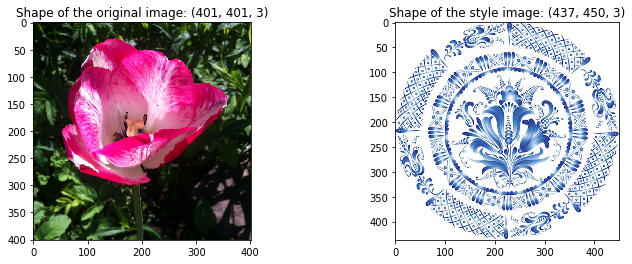

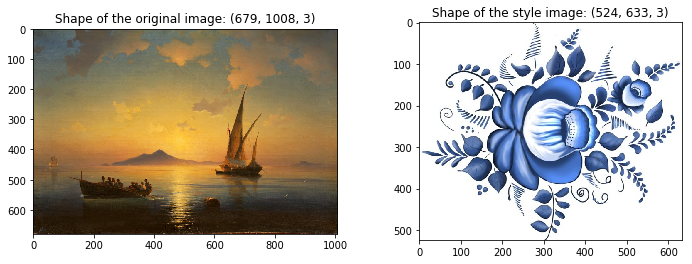

In [3]:
display_images('picture03.png','pattern03.png')
display_images('picture02.png','pattern02.png')

# Preprocessing

In [4]:
# Create image tensors and resize the biggest one; Pair 1
picture01=cv2.imread(fpath+'picture03.png').astype('float32')
pattern01=cv2.imread(fpath+'pattern03.png').astype('float32')
picture01=cv2.resize(picture01,(400,400)).astype('float32')
pattern01=cv2.resize(pattern01,(400,400)).astype('float32')
picture01.shape,pattern01.shape

((400, 400, 3), (400, 400, 3))

In [5]:
# Create image tensors and resize the biggest one; Pair 2
picture02=cv2.imread(fpath+'picture02.png').astype('float32')
pattern02=cv2.imread(fpath+'pattern02.png').astype('float32')
picture02=cv2.resize(picture02,(630,520)).astype('float32')
pattern02=cv2.resize(pattern02,(630,520)).astype('float32')
picture02.shape,pattern02.shape

((520, 630, 3), (520, 630, 3))

In [6]:
# Preprocess function for VGG16
def preprocess(img):
    img=img.copy(); img=np.expand_dims(img,axis=0) 
    return ks.applications.vgg16.preprocess_input(img)

In [7]:
# Reverse of preprocessing
def deprocess(img):
    img=img.copy()[0]                        
    img[:,:,0]+=103.939; img[:,:,1]+=116.779; img[:,:,2]+=123.68             
    img=img[:,:,::-1]              
    img=np.clip(img,0,255)         
    return img.astype('uint8') 

In [8]:
# Function for input tensors
def inputs(original_img,style_img):
    original_input=tf.constant(preprocess(original_img))
    style_input=tf.constant(preprocess(style_img))
    generated_input=tf.placeholder(tf.float32,original_input.shape)
    return original_input,style_input,generated_input

In [9]:
# Create input tensors
original_input,style_input,generated_input=inputs(picture01,pattern01)
input_tensor=tf.concat([original_input,style_input,generated_input],axis=0)
original_input2,style_input2,generated_input2=inputs(picture02,pattern02)
input_tensor2=tf.concat([original_input2,style_input2,generated_input2],axis=0)
[input_tensor.shape,input_tensor2.shape]

[TensorShape([Dimension(3), Dimension(400), Dimension(400), Dimension(3)]),
 TensorShape([Dimension(3), Dimension(520), Dimension(630), Dimension(3)])]

# VGG16 Usage

In [10]:
# Create the model using keras applications; Pair 1
vgg16_model=ks.applications.vgg16.\
VGG16(weights=mw,input_tensor=input_tensor,include_top=False)
# Create layer dictionaries
vgg16_layer_dict={layer.name:layer for layer in vgg16_model.layers}
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [11]:
# Create the model using keras applications; Pair 2
vgg16_model2=ks.applications.vgg16.\
VGG16(weights=mw,input_tensor=input_tensor2,include_top=False)
# Create layer dictionaries
vgg16_layer_dict2={layer.name:layer for layer in vgg16_model2.layers}

In [12]:
def calculate_original_loss(layer_dict,original_layer_names):
    loss=0
    for name in original_layer_names:
        layer=layer_dict[name]
        original_features=layer.output[0,:,:,:]  
        generated_features=layer.output[2,:,:,:] 
        loss+=ks.backend.sum(ks.backend.square(generated_features-original_features))
    return loss/len(original_layer_names)
def gram_matrix(x):    
    features=ks.backend.batch_flatten(ks.backend.permute_dimensions(x,(2,0,1))) 
    gram=ks.backend.dot(features,ks.backend.transpose(features))
    return gram
def get_style_loss(style_features,generated_features,size):
    S=gram_matrix(style_features)
    G=gram_matrix(generated_features)
    channels=3
    return ks.backend.sum(ks.backend.square(S-G))/(4.*(channels**2)*(size**2))
def calculate_style_loss(layer_dict,style_layer_names,size):
    loss=0
    for name in style_layer_names:
        layer=layer_dict[name]
        style_features=layer.output[1,:,:,:] 
        generated_features=layer.output[2,:,:,:] 
        loss+=get_style_loss(style_features,generated_features,size) 
    return loss/len(style_layer_names)
def calculate_variation_loss(x):
    row_diff=ks.backend.square(x[:,:-1,:-1,:]-x[:,1:,:-1,:])
    col_diff=ks.backend.square(x[:,:-1,:-1,:]-x[:,:-1,1:,:])
    return ks.backend.sum(ks.backend.pow(row_diff+col_diff,1.25))

In [13]:
# Calculate all losses
original_loss=calculate_original_loss(vgg16_layer_dict,['block5_conv2'])
style_loss=calculate_style_loss(vgg16_layer_dict,style_layers, 
                                pattern01.shape[0]*pattern01.shape[1])
variation_loss=calculate_variation_loss(generated_input)
original_loss2=calculate_original_loss(vgg16_layer_dict2,['block5_conv2'])
style_loss2=calculate_style_loss(vgg16_layer_dict2,style_layers, 
                                 pattern02.shape[0]*pattern02.shape[1])
variation_loss2=calculate_variation_loss(generated_input2)

In [14]:
### Pair 1 ###
# Loss and gradients calculation
loss=.5*original_loss+1.*style_loss+.1*variation_loss       
gradients=ks.backend.gradients(loss,generated_input)[0]
calculate=ks.backend.function([generated_input],[loss,gradients])
# Preprocess the image
generated_data=preprocess(picture01)
# Generate the new image 
for i in tqdm(range(100)):
    _,gradients_value=calculate([generated_data])
    generated_data-=gradients_value*.001

100%|██████████| 100/100 [00:13<00:00,  7.17it/s]


In [15]:
### Pair 2 ###
# Loss and gradients calculation
loss2=.5*original_loss2+1.*style_loss2+.1*variation_loss2    
gradients2=ks.backend.gradients(loss2,generated_input2)[0]
calculate2=ks.backend.function([generated_input2],[loss2,gradients2])
# Preprocess the image
generated_data2=preprocess(picture02)
# Generate the new image 
for i in tqdm(range(300)):
    _,gradients_value2=calculate2([generated_data2])
    generated_data2-=gradients_value2*.001

100%|██████████| 300/300 [00:49<00:00,  6.06it/s]


## Generated Images

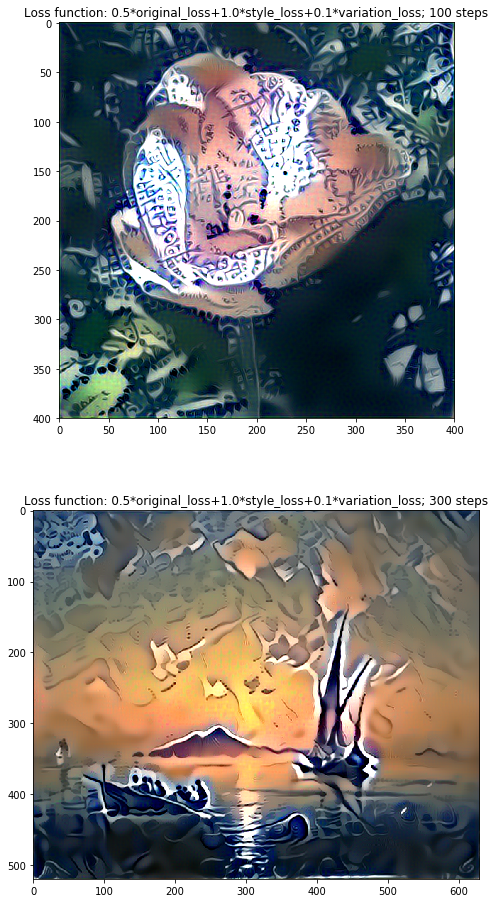

In [16]:
generated_image01=deprocess(generated_data)
generated_image02=deprocess(generated_data2)
pl.figure(1,figsize=(8,16))
pl.subplot(211)
pl.title("Loss function: 0.5*original_loss+1.0*style_loss+0.1*variation_loss; 100 steps")
pl.imshow(cv2.cvtColor(generated_image01,cv2.COLOR_BGR2RGB))
pl.subplot(212)
pl.title("Loss function: 0.5*original_loss+1.0*style_loss+0.1*variation_loss; 300 steps")
pl.imshow(cv2.cvtColor(generated_image02,cv2.COLOR_BGR2RGB))
pl.show()

# One More Time
# Displaying Vertical Images

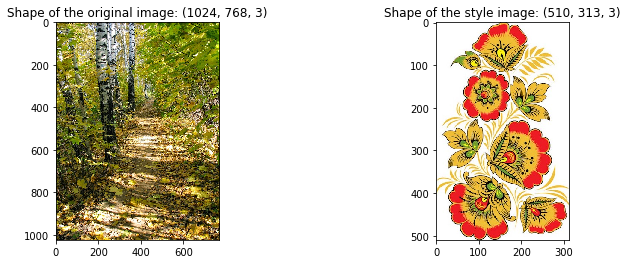

In [17]:
display_images('picture01.png','pattern01.png')

# Preprocessing

In [18]:
def rr_img(image,angle,width,height):
    [h,w]=image.shape[:2]; x,y=w//2,h//2
    M=cv2.getRotationMatrix2D((x,y),-angle,1.)
    cos,sin=np.abs(M[0,0]),np.abs(M[0,1])
    nw,nh=int((h*sin)+(w*cos)),int((h*cos)+(w*sin))
    M[0,2]+=(nw/2)-x; M[1,2]+=(nh/2)-y
    img=cv2.warpAffine(image,M,(nw,nh))
    return cv2.resize(img,(width,height)).astype('float32')

In [19]:
picture01=cv2.imread(fpath+'picture01.png').astype('float32')
pattern01=cv2.imread(fpath+'pattern01.png').astype('float32')
picture01=rr_img(picture01,90,600,400)
pattern01=rr_img(pattern01,90,600,400)
picture01.shape,pattern01.shape

((400, 600, 3), (400, 600, 3))

In [20]:
original_input,style_input,generated_input=\
inputs(picture01,pattern01)
input_tensor=tf.concat([original_input,style_input,
                        generated_input],axis=0)
input_tensor.shape

TensorShape([Dimension(3), Dimension(400), Dimension(600), Dimension(3)])

# VGG16 Usage

In [21]:
vgg16_model=ks.applications.vgg16.\
VGG16(input_tensor=input_tensor,include_top=False)
vgg16_layer_dict={layer.name:layer for layer in vgg16_model.layers}

58892288/58889256 [==============================] - 1s 0us/step


In [22]:
original_loss=calculate_original_loss(vgg16_layer_dict,['block5_conv2'])
style_loss=calculate_style_loss(vgg16_layer_dict,style_layers, 
                                pattern01.shape[0]*pattern01.shape[1])
variation_loss=calculate_variation_loss(generated_input)

# Generated Images

In [23]:
loss=.5*original_loss+1.*style_loss+.1*variation_loss    
gradients=ks.backend.gradients(loss,generated_input)[0]
calculate=ks.backend.function([generated_input],[loss,gradients])
generated_data=preprocess(picture01) 
for i in tqdm(range(30)):
    _,gradients_value=calculate([generated_data])
    generated_data-=gradients_value*.001

100%|██████████| 30/30 [00:04<00:00,  6.34it/s]


In [24]:
loss=.7*original_loss+1.*style_loss+.1*variation_loss    
gradients=ks.backend.gradients(loss,generated_input)[0]
calculate=ks.backend.function([generated_input],[loss,gradients])
generated_data2=preprocess(picture01) 
for i in tqdm(range(300)):
    _,gradients_value=calculate([generated_data2])
    generated_data2-=gradients_value*.001

100%|██████████| 300/300 [00:36<00:00,  8.32it/s]


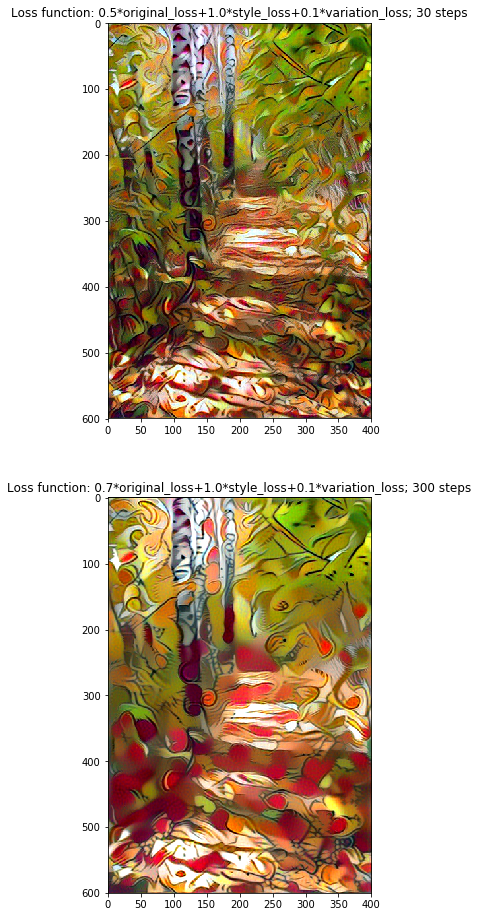

In [25]:
generated_image01=deprocess(generated_data)
generated_image02=deprocess(generated_data2)
generated_image01=rr_img(generated_image01,270,400,600)/255
generated_image02=rr_img(generated_image02,270,400,600)/255
pl.figure(1,figsize=(8,16))
pl.subplot(211)
pl.title("Loss function: 0.5*original_loss+1.0*style_loss+0.1*variation_loss; 30 steps")
pl.imshow(cv2.cvtColor(generated_image01,cv2.COLOR_BGR2RGB))
pl.subplot(212)
pl.title("Loss function: 0.7*original_loss+1.0*style_loss+0.1*variation_loss; 300 steps")
pl.imshow(cv2.cvtColor(generated_image02,cv2.COLOR_BGR2RGB))
pl.show()